In [1]:
#
import heyoka as hy
import numpy as np
import matplotlib as plt
import math
from copy import deepcopy

#
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

We show how to use heyoka to study the system sentitivities when terminal events are enforced. That is, how does the final state vary when we perturb the initial conditions and parameters and the integration time is decided by a terminal event?

Let us consider a generic set of ODEs:

$$
\left\{
\begin{array}{l}
\mathbf {\dot x} = \mathbf f(\mathbf x) \\
\mathbf {x(0)} = \mathbf x_0
\end{array}
\right.
$$
and express its solution as $\mathbf x(t, \mathbf x_0)$.
Let us now perform a numerical integration and stop at the time $T$ when some event condition $\mathbf e(\mathbf x(T, \mathbf x_0)) = \mathbf 0$ is satisfied. 
If we repeat the numerical integration from slightly perturbed initial conditions, the time at which the event is triggered also will also be perturbed so that:
$$
\mathbf e\big(\mathbf x(T + \delta T, \mathbf x_0 + \delta \mathbf x_0)\big) = \mathbf 0
$$

We will now see how to use *heyoka* to obtain polinomial expansions $\mathcal P$ of arbitrary order of the final state and the event trigger time. That is, we seek to find:

$$
\left\{
\begin{array}{l}
\mathbf x_f = \mathcal P_{x_f}^n(\delta \mathbf x_0, \delta T)\\
\delta T = \mathcal P_T^n(\delta \mathbf x_0)
\end{array}
\right.
$$

This all seems a bit complicated at this point, so it may help to imagine it before we start: we are building high degree polinomials representing how the results of a numerical integration stopped by some event change with the initial conditions. Take, as an example, a particle a gravity field and free falling up to when it collides with a spherical surface placed beneath it. **We want to describe the point where the particle collides with the sphere as a function of its initial state.**

Let us start to define our dynamical system $\mathbf f$:


In [2]:
# Create the symbolic variables for the state.
x, y, vx, vy = hy.make_vars("x", "y", "vx", "vy")

r = hy.sqrt(x**2 + y**2)
dyn = [vx, vy, -1.0 / r**3 * x, -1.0 / r**3 * y]
sys = []
sys.append((x, dyn[0]))
sys.append((y, dyn[1]))
sys.append((vx, dyn[2]))
sys.append((vy, dyn[3]))

and the event $\mathbf e$:

In [3]:
# Let us create the event
# Callback for the terminal event.
def t_cb(ta, d_sgn):
    # Do stop the integration.
    return False

# Define a terminal event that turns air drag on/off
# whenever the velocity goes to zero.
ev_expr = x**2 + y**2 -1
t_ev = hy.t_event(
        # The event equation.
        ev_expr,
        # The callback.
        callback = t_cb)

In [4]:
# Construct the Taylor integrator containing also variational equations
ta = hy.taylor_adaptive(sys, [.1]*4, compact_mode=True, t_events = [t_ev])

In [5]:
# Lets propagate 
ic = [0, 2., 0.4, 0.] 
tof = 6.

ta.state[:4] = ic 

ta.time = 0.
ta.reset_cooldowns() # to be sure in case we evaluatre the cell twice in a row

t_grid_ta = np.linspace(0., tof)

out_ta = ta.propagate_grid(t_grid_ta)

trigger_time = ta.time
print("The event triggers at: ", trigger_time)


The event triggers at:  3.207317144145824


The numerical propagation has terminated but, while the state of the *ta* object is the one at the event time trigger, the actual values contained in the array returned by *propagate_grid* miss this last point as its not on the requested grid. We thus create new variables and append there the necessary values.

In [6]:
out = np.vstack((out_ta[-1], ta.state.reshape(1,-1)))
t_grid = t_grid_ta[t_grid_ta<ta.time]
t_grid = np.hstack((t_grid, [ta.time]))

Lets have a look to what happened:

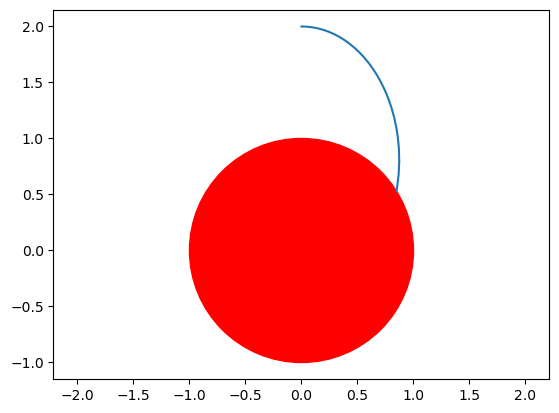

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(out[:,0], out[:,1])

circle = plt.Circle((0, 0), 1, color='r')
ax.add_patch(circle)
plt.axis('equal');

Naturally, our object followed some kind of Keplerian orbit and stopped when it hit the sphere. So far so good. In order now to understand where the object would hit the sphere if we change the initial conditions, we need to transform our set of ODEs applying a few tricks. We started from:

$$
\left\{
\begin{array}{l}
\mathbf {\dot x} = v_x \\
\mathbf {\dot y} = v_y \\
\mathbf {\dot v_x} = - x/r^3 \\
\mathbf {\dot v_y} = - y/r^3 \\
\end{array}
\right.
$$

and the event $e = x^2 + y^2 -1 = 0$.

and we integrated up to the event rigger time $T$. Let us now instead consider the ODE system:
$$
\left\{
\begin{array}{l}
\mathbf {\dot x} = T v_x \\
\mathbf {\dot y} = T v_y \\
\mathbf {\dot v_x} = - T x/r^3 \\
\mathbf {\dot v_y} = - T y/r^3 \\
\mathbf {\dot e} = T \nabla e \cdot \mathbf f
\end{array}
\right.
$$
with the added initial condition $e(0)$. We will integrate this system up to 1, as we now moved the integration time as an ODE parameter. We also added one equation which will track the event value along the dynamics.

On this system of equations we now build a variational integrator so that all high orders variations will also be computed:


In [8]:
e = hy.make_vars("e")
ev_cfunc = hy.cfunc([ev_expr], vars=[x, y, vx, vy])

ev_grad = hy.diff_tensors([ev_expr], diff_args=[x, y, vx, vy], diff_order=1).gradient

sys_aug = []
sys_aug.append((x, hy.par[0] * dyn[0]))
sys_aug.append((y, hy.par[0] * dyn[1]))
sys_aug.append((vx, hy.par[0] * dyn[2]))
sys_aug.append((vy, hy.par[0] * dyn[3]))
sys_aug.append((e, hy.par[0] * np.dot(ev_grad, dyn)))

we compute the variational system:

In [9]:
# Create the variational ODE system (symbolic).
vsys = hy.var_ode_sys(sys_aug, [x, y, vx, vy, e, hy.par[0]], order=5)

and build a variational integrator including the integration time as parameter.

In [10]:
# Construct the Taylor integrator containing also variational equations (llvm)
ta_var = hy.taylor_adaptive(vsys, [.1]*5, compact_mode=True, t_events = [t_ev])
# We store the initial conditions on the variational equations for future resets
ic_var = ta_var.state[5:]

We thus may now integrate this system up to a unitary time ($T$ will take care of scaling it to the real time units)

In [11]:
# Lets propagate 
ic_aug = ic + [ev_cfunc(ic)[0]] 

ta_var.state[:5] = ic_aug 
ta_var.state[5:] = ic_var
ta_var.pars[:] = trigger_time

ta_var.time = 0.
ta_var.reset_cooldowns()

t_grid_ta_var = np.linspace(0., 1.)

out_ta = ta_var.propagate_grid(t_grid_ta_var)

Just to verify, lets look at the value of $e$ at the end of our integration and check that is zero indeed:

In [12]:
print("The event state variable e value at the end is: ", ta_var.state[4])

The event state variable e value at the end is:  1.618580474398356e-15


Here is perhaps a good place to stop for a second and try to understand what we have computed. Looking into how we defined and built the variational equations, it should be easy to see that calls to the method *evaluate_taylormap* will return the following quantities:


$$
\left\{
\begin{array}{l}
\delta x_f = \mathcal P_{x_f}^n(\delta x_f, \delta y_f, \delta v_{x_f}, \delta v_{y_f}, \delta T)\\
\delta y_f = \mathcal P_{y_f}^n(\delta x_f, \delta y_f, \delta v_{x_f}, \delta v_{y_f}, \delta T)\\
\delta v_{x_f} = \mathcal P_{v_{x_f}}^n(\delta x_f, \delta y_f, \delta v_{x_f}, \delta v_{y_f}, \delta T)\\
\delta v_{y_f} = \mathcal P_{v_{y_f}}^n(\delta x_f, \delta y_f, \delta v_{x_f}, \delta v_{y_f}, \delta T)\\
\delta e_f = \mathcal P_T^n(\delta x_f, \delta y_f, \delta v_{x_f}, \delta v_{y_f}, \delta T)
\end{array}
\right.
$$

where $\mathcal P^n$ are multivariate polynomials of order $n$. Comparing this to what we wanted to compute we can see that we are getting very close, except the last equation, where we would rather have something like $\delta T = \mathcal P_T^n(\delta x_f, \delta y_f, \delta v_{x_f}, \delta v_{y_f}, \delta e_f)$ to then set $\delta e_f=0$. We need to invert this last equation!

# A prototype in heyoka

In [13]:
def _compute_direct_map(state, vargs, ta_var, identity=[]):
    M = [0] * len(state)
    N = [hy.expression(0)] * len(state)
    matrix = np.zeros((len(state), len(state)))

    # 1 - We create the symbols for the polynomial system of equations: dx = P(dy)
    state_s = []
    vargs_s = []
    for i in range(len(state)):
        state_s.append("dx" + str(i))
    for i in range(len(vargs)):
        vargs_s.append("dy" + str(i))
    state_e = hy.make_vars(*state_s)
    vargs_e = hy.make_vars(*vargs_s)
    # In case state or vargs are only of len 1, the return value in heyoka changes type and is not a list.
    # We account for this case here
    if not isinstance(state_e, list):
        state_e = [state_e]
    if not isinstance(vargs_e, list):
        vargs_e = [vargs_e]

    # 2 - We build the indexes of the vargs to ignore
    allidxs = set(range(len(ta_var.vargs)))
    ignore = allidxs - set(vargs)

    # 3 - We loop over all mini indexes
    for i in range(ta_var.n_orig_sv, len(ta_var.sys)):
        mindex = ta_var.get_mindex(i)
        # If the state is in the identity list we build the map dx = dy and continue
        if mindex[0] in identity:  
            # This is now done multiple times, but could be done only the first.
            M[state.index(mindex[0])] = vargs_e[mindex[0]]
            matrix[state.index(mindex[0]), state.index(mindex[0])] = 1.0
            continue
        
        # If not, we only consider the term if it corresponds to a selected state
        if not mindex[0] in state:
            continue
        # .. and contains only the selected vargs
        flag = 0.0
        for ii, jj in enumerate(mindex[1:]):
            if  (not (ii in vargs)) and (jj > 0.0):
                flag=1.0
                break

        if flag == 0:
            # At this point we know we need to add this term to the corresponding map.
            monomial = 1.0
            for k in range(len(vargs)):
                monomial *= vargs_e[k] ** mindex[vargs[k] + 1]
            value = ta_var.state[i]
            factorial = math.prod([math.factorial(_) for _ in mindex[1:]])

            value /= factorial
            if sum(mindex[1:]) == 1:
                M[state.index(mindex[0])] += value * monomial
                matrix[state.index(mindex[0]), vargs.index(mindex[1:].index(1))] = value
            else:
                N[state.index(mindex[0])] += value * monomial
    return state_e, vargs_e, M, N, matrix


def _map_composition_hy(A, B, symbols):
    tmp = deepcopy(A)
    for j in range(len(symbols)):
        tmp = hy.subs(tmp, {symbols[j]: B[j]})
    return tmp


def _map_difference(A, B):
    C = []
    for i in range(len(A)):
        C.append(A[i] - B[i])
    return C


def _map_sum(A, B):
    C = []
    for i in range(len(A)):
        C.append(A[i] + B[i])
    return C


# This inverts the linear equations from ta_var dx = P(dy) where the components in
# dx are the selctes state, and the ones in dy the vargs. 
# Anything in identity will be not from ta_var, but just the identity map.
def invert_taylor_map(state, vargs, ta_var, identity=[]):
    if len(state) != len(vargs):
        raise ValueError("Dimension for state must equal the dimension for vargs")
    n = ta_var.vorder
    # 1 - we create the direct map and it linear nonlinear part
    dx_e, dy_e, M, N, matrix = _compute_direct_map(state, vargs, ta_var, identity)
    Identity = dx_e
    # 2 - We assemple the linear part with 2 different symbols as to avoid nasty surprises in subs
    det = np.linalg.det(matrix)
    if abs(det) < 1e-10:
        raise ValueError("Linear Map is not invertible")
    Minv0 = list(np.linalg.inv(matrix) @ dx_e)  # dx symbols
    Minv02 = _map_composition_hy(Minv0, dy_e, dx_e)  # dy symbols
    # 3 - We iterate n times
    for i in range(n - 1):
        Minv0 = _map_composition_hy(
            Minv02, _map_difference(Identity, _map_composition_hy(N, Minv0, dy_e)), dy_e
        )
    cfunc = hy.cfunc(Minv0, vars=dx_e)
    return cfunc

It is always good to confirm what are the variational variables we have considered:

In [14]:
print("The variational variables are, in order: ", ta_var.vargs)

The variational variables are, in order:  [x, y, vx, vy, e, p0]


In [15]:
state = [0,1,2,3,4] # selects the maps for dx_f, dy_f, dvx_f, dvy_f, de_f
vargs = [0,1,2,3,5] # selects to have the variations w.r.t. dx_0, dy_0, dvx_0, dvy_0, dT

identity = [0,1,2,3] # overrides the dx_f, dy_f, dvx_f, dvy_f with dx_0, dy_0, dvx_0, dvy_0

# Inverts the map. 
invmap = invert_taylor_map(state, vargs, ta_var, identity=identity)
_, _, _, _, matrix = _compute_direct_map(state,vargs,ta_var,identity)

In [16]:
ta_var.vargs

[x, y, vx, vy, e, p0]

In [17]:
ta_var.state[29:35]

array([ 1.69673001,  1.11884781,  6.49603885,  8.48365006,  1.        ,
       -1.44222051])

In [18]:
ta_var.get_mindex(29)

[4, 1, 0, 0, 0, 0, 0]

In [19]:
matrix

array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ],
       [ 1.69673001,  1.11884781,  6.49603885,  8.48365006, -1.44222051]])

In [22]:
size = 1e-4
d_ic = [np.random.random()*size, np.random.random()*0.0, np.random.random()*size, np.random.random()*size]
# We now use the random perturbation vector generated above (dx_0, dy_0, dvx_0, dvy_0) add de_f=0 and query the map for
# the change in event trigger time:
dT = invmap(d_ic+[0.])
print("Event trigger time difference from the Taylor approximation:", dT[-1])
print("Event trigger time difference from the Linear approximation:", (np.linalg.inv(matrix)@(d_ic+[0.]))[-1])


Event trigger time difference from the Taylor approximation: 0.0007658677154722984
Event trigger time difference from the Linear approximation: 0.0007656725682678042


In [23]:
# Lets propagate using the original system (non augmented, non variational)
ic_new = np.array(ic) + np.array(d_ic)
tof = 6.

ta.state[:4] = ic_new 

ta.time = 0.
ta.reset_cooldowns()

t_grid_ta = np.linspace(0., tof)

out_ta_new = ta.propagate_grid(t_grid_ta)

trigger_time_new = ta.time

print("Old event trigger time:", trigger_time)
print("New event trigger time:", trigger_time_new)
print(f"\nEvent trigger time difference:\t\t\t\t\t{trigger_time_new - trigger_time:.5e}")
print(f"Event trigger time difference from the Taylor approximation:\t{dT[-1]:.5e}\t")
print("\nRelative error (on dT, not T): ", (dT[-1] - (trigger_time_new -trigger_time )) / (trigger_time_new -trigger_time ))


Old event trigger time: 3.207317144145824
New event trigger time: 3.2080830119452326

Event trigger time difference:					7.65868e-04
Event trigger time difference from the Taylor approximation:	7.65868e-04	

Relative error (on dT, not T):  -1.0959643843350826e-07
